<a href="https://colab.research.google.com/github/SupreethRao99/DeepCAPTCHA/blob/main/DeepCAPTCHA_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepCAPTCHA
DeepCAPTHA is a ResNet architecture based convolutional neural network (CNN) trained on the [Chars74K-Fonts](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/#download) Dataset. It has been built as part of a larger project which attempts to defeat simple CAPTCHAs. The Network trained in this notebook achieves a training accuracy of 92.5% and a validation accuracy of 90.41%.

The [dataset](https://www.kaggle.com/supreethrao/chars74kdigitalenglishfont) used in this notebook can also be found on kaggle

## Setup and Preprocessing

In [ ]:
# importing the required libraries
import numpy as np
import os 
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm, trange
from google.colab import drive
import zipfile
import random
from shutil import copyfile

In [ ]:
# setting up Weights and Biases for experiment tracking
%%capture
!pip intall wandb

import wandb
from wandb.keras import WandbCallback
wandb.login()

In [ ]:
# Configuring Hyperparameters

run = wandb.init(project='DeepCAPTCHA',
           config={
              "epochs": 50,
              "batch_size": 32,
              "img_height":32,
              "img_width":32,
              "validation_split":0.2,
              "Dropout":0.6,
              "num_classes":62,
              "loss_function": "sparse_categorical_crossentropy",
              "architecture": "ResNet ",
              "dataset": "English-CAPTCHA"
           },
           )
config = wandb.config

## Download the Dataset

The dataset is stored on google drive. The dataset is then loaded onto colab and unzipped.

In [ ]:
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/English.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
# Training and testing directories are created with directory name being the
# label of the class. eg:images of the letter 'A' will be in directory 'A'
# similarly images of letter 'a' will be in directory 'a'.

# Note that directory names are case-sensitive.
os.mkdir('/tmp/CAPTCHA')

for i in tqdm(range(0,62)):
  try:
    if i>= 0 and i<10: # for numbers 0-9
      os.mkdir('/tmp/CAPTCHA/'+chr(i+48))

    if i>= 10 and i<36: # for alphabets A-Z
      os.mkdir('/tmp/CAPTCHA/'+chr(i-10+65))
      
    if i>=36 and i<62: # for alphabets a-z
      os.mkdir('/tmp/CAPTCHA/'+chr(i-36+97))
      
  except OSError:
    print('directory creation failed')
    pass

we clean up the downloaded data and move the files into their corresponding directories under the root directory of `tmp/CAPTCHA`

In [ ]:
source = '/tmp/English/Fnt/'
dst = '/tmp/CAPTCHA/'

for folder in tqdm(os.listdir(source)):
  if folder[0] in os.listdir(dst):
    for fname in os.listdir(source+str(folder)):
      shutil.copyfile(source+folder+'/'+str(fname),dst+str(folder[0])+'/'+str(fname))

# Creation of Model



# Load data using `tf.keras.preprocessing`

In [ ]:
batch_size = config.batch_size
img_height = config.img_height
img_width = config.img_width

data_dir ='/tmp/CAPTCHA/'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=config.validation_split,
  subset="training",
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 62992 files belonging to 62 classes.
Using 50394 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=config.validation_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 62992 files belonging to 62 classes.
Using 12598 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Visualize the data

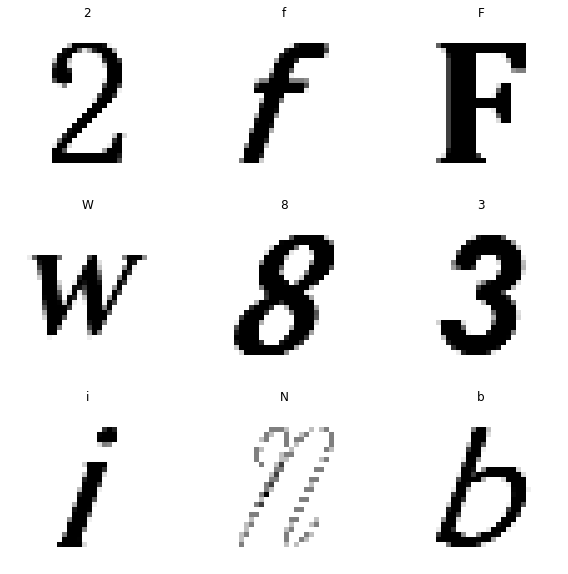

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## The ResNet Model
the model described below uses a custom model based on the [ResNet architecture](https://arxiv.org/pdf/1512.03385.pdf) 

In [ ]:
import keras
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def get_config(self):
      cfg = super().get_config()
      return cfg  

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
def createmodel():
  model = keras.models.Sequential()
  # Augments the image
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
  model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.125))

  model.add(DefaultConv2D(64, kernel_size=4, strides=2,
                        input_shape=[32, 32, 3]))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("relu"))
  model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
  prev_filters = 64
  for filters in [64] * 3 + [128] * 2 :
      strides = 1 if filters == prev_filters else 2
      model.add(ResidualUnit(filters, strides=strides))
      prev_filters = filters
  model.add(keras.layers.GlobalAvgPool2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(config.Dropout))
  model.add(keras.layers.Dense(config.num_classes))
  
  return model

In [ ]:
# performance scheduling is used to reduce learning rate
# to improve model training accuracy

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.6, patience=2,min_lr=0.000001,cooldown=2,mode='auto')

In [ ]:
model = createmodel()
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_ds, epochs = config.epochs,
                    validation_data=val_ds,
            callbacks=[WandbCallback(), learning_rate_reduction])

Epoch 1/50
1575/1575 [==============================] - 96s 23ms/step - loss: 2.3506 - accuracy: 0.3994 - val_loss: 1.3905 - val_accuracy: 0.5880


wandb: ERROR Can't save model, h5py returned error: Layer ModuleWrapper has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/50
1575/1575 [==============================] - 18s 12ms/step - loss: 0.7847 - accuracy: 0.7495 - val_loss: 0.7025 - val_accuracy: 0.7562
Epoch 3/50
1575/1575 [==============================] - 19s 12ms/step - loss: 0.6489 - accuracy: 0.7813 - val_loss: 0.7438 - val_accuracy: 0.7633
Epoch 4/50
1575/1575 [==============================] - 19s 12ms/step - loss: 0.5871 - accuracy: 0.7903 - val_loss: 0.5234 - val_accuracy: 0.8151
Epoch 5/50
1575/1575 [==============================] - 18s 12ms/step - loss: 0.5468 - accuracy: 0.8049 - val_loss: 0.4664 - val_accuracy: 0.8309
Epoch 6/50
1575/1575 [==============================] - 19s 12ms/step - loss: 0.5083 - accuracy: 0.8155 - val_loss: 0.4895 - val_accuracy: 0.8331
Epoch 7/50
1575/1575 [==============================] - 19s 12ms/step - loss: 0.4806 - accuracy: 0.8246 - val_loss: 0.4711 - val_accuracy: 0.8318
Epoch 8/50
1575/1575 [==============================] - 18s 11ms/step - loss: 0.4583 - accuracy: 0.8328 - val_loss: 0.4149 -

In [ ]:
run.finish()

epoch,49
loss,0.17165
accuracy,0.92539
val_loss,0.2493
val_accuracy,0.90411
_runtime,1212
_timestamp,1627123372
_step,49
best_val_loss,0.24847
best_epoch,47


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▄▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇███▇███████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


The model is saved in the `saved_model` format and downloaded for use as part of the larger project.

In [ ]:
model.save('CAPTCHA-Model')

In [ ]:
!zip -r /content/CAPTCHA.zip /content/CAPTCHA-Model

In [ ]:
from google.colab import files
files.download("/content/CAPTCHA.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>